In [ ]:
import pandas as pd
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

In [ ]:
df = pd.read_csv("Cleaned_Tickets.csv")
df.shape

(16337, 9)

In [ ]:
# 1. Imports & Seed Setup

import pandas as pd
import numpy as np
import torch
import random

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [ ]:
# 2. Load & Preprocess Data

# Combine text fields
df["text"] = df["subject"].fillna('') + " " + df["body"].fillna('')

le = LabelEncoder()
df["label"] = le.fit_transform(df["department"])
num_classes = len(le.classes_)

# Train/val/test split
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=seed)
train_df, val_df  = train_test_split(train_df, test_size=0.1, stratify=train_df["label"], random_state=seed)

In [ ]:
# 3. Tokenizer Setup
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def tokenize_batch(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_attention_mask=True,
        return_tensors="pt"
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# 4. PyTorch Dataset Class

class DeptDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": tokens["input_ids"].squeeze(0),
            "attention_mask": tokens["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# 5. Dataloaders

train_ds = DeptDataset(train_df["text"], train_df["label"], tokenizer)
val_ds   = DeptDataset(val_df["text"], val_df["label"], tokenizer)
test_ds  = DeptDataset(test_df["text"], test_df["label"], tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)

In [ ]:
# 6. Model Definition

class BERTDeptClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        return self.classifier(x)

In [ ]:
# 7. Optimizer, Scheduler, and Loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTDeptClassifier(num_classes=num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# 8. Training & Evaluation Functions

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    progress_bar = tqdm(loader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy


def eval_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    val_loss = 0

    progress_bar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix(loss=loss.item())

    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    return val_loss / len(loader), report


In [ ]:
# 9. Training Loop with Logs & Scheduler

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_f1 = -1
patience = 3
epochs_since_improvement = 0
num_epochs = 50
checkpoint_path = "best_dept_model.pt"

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_report = eval_model(model, val_loader)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_report["accuracy"])

    f1 = val_report["weighted avg"]["f1-score"]
    prec = val_report["weighted avg"]["precision"]
    recall = val_report["weighted avg"]["recall"]

    improved = f1 > best_f1
    if improved:
        best_f1 = f1
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Epoch {epoch:02d}: new best F1={best_f1:.4f}, saved checkpoint.")
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
          f"| F1: {f1:.4f} | Prec: {prec:.4f} | Recall: {recall:.4f}")

    if epochs_since_improvement >= patience:
        print(f"Stopping early at epoch {epoch}.")
        break

Epoch 01: new best F1=0.3644, saved checkpoint.
Epoch 01 | Train Loss: 1.7338 | Val Loss: 1.5964 | F1: 0.3644 | Prec: 0.5113 | Recall: 0.4269


Epoch 02: new best F1=0.3942, saved checkpoint.
Epoch 02 | Train Loss: 1.4958 | Val Loss: 1.5100 | F1: 0.3942 | Prec: 0.4738 | Recall: 0.4453


Epoch 03: new best F1=0.5287, saved checkpoint.
Epoch 03 | Train Loss: 1.2258 | Val Loss: 1.3692 | F1: 0.5287 | Prec: 0.5467 | Recall: 0.5364


Epoch 04: new best F1=0.5630, saved checkpoint.
Epoch 04 | Train Loss: 0.8836 | Val Loss: 1.3540 | F1: 0.5630 | Prec: 0.5797 | Recall: 0.5649


Epoch 05: new best F1=0.6121, saved checkpoint.
Epoch 05 | Train Loss: 0.5718 | Val Loss: 1.3451 | F1: 0.6121 | Prec: 0.6240 | Recall: 0.6186


Epoch 06: new best F1=0.6444, saved checkpoint.
Epoch 06 | Train Loss: 0.3734 | Val Loss: 1.3907 | F1: 0.6444 | Prec: 0.6569 | Recall: 0.6499


Epoch 07: new best F1=0.6460, saved checkpoint.
Epoch 07 | Train Loss: 0.2528 | Val Loss: 1.4867 | F1: 0.6460 | Prec: 0.6671 | Recall: 0.6506


Epoch 08: new best F1=0.6667, saved checkpoint.
Epoch 08 | Train Loss: 0.1893 | Val Loss: 1.4669 | F1: 0.6667 | Prec: 0.6706 | Recall: 0.6683


Epoch 09: new best F1=0.6809, saved checkpoint.
Epoch 09 | Train Loss: 0.0908 | Val Loss: 1.5758 | F1: 0.6809 | Prec: 0.6863 | Recall: 0.6846


Epoch 10: new best F1=0.6900, saved checkpoint.
Epoch 10 | Train Loss: 0.0537 | Val Loss: 1.6067 | F1: 0.6900 | Prec: 0.6916 | Recall: 0.6900


Epoch 11 | Train Loss: 0.0496 | Val Loss: 1.7600 | F1: 0.6882 | Prec: 0.7000 | Recall: 0.6907


Epoch 12: new best F1=0.6997, saved checkpoint.
Epoch 12 | Train Loss: 0.0309 | Val Loss: 1.7244 | F1: 0.6997 | Prec: 0.7052 | Recall: 0.7022


Epoch 13: new best F1=0.7023, saved checkpoint.
Epoch 13 | Train Loss: 0.0217 | Val Loss: 1.7355 | F1: 0.7023 | Prec: 0.7106 | Recall: 0.7036


Epoch 14 | Train Loss: 0.0228 | Val Loss: 1.7626 | F1: 0.6935 | Prec: 0.7048 | Recall: 0.6948


Epoch 15 | Train Loss: 0.0133 | Val Loss: 1.7712 | F1: 0.7014 | Prec: 0.7081 | Recall: 0.7016


Epoch 16: new best F1=0.7105, saved checkpoint.
Epoch 16 | Train Loss: 0.0106 | Val Loss: 1.8132 | F1: 0.7105 | Prec: 0.7202 | Recall: 0.7111


Epoch 17: new best F1=0.7112, saved checkpoint.
Epoch 17 | Train Loss: 0.0088 | Val Loss: 1.8358 | F1: 0.7112 | Prec: 0.7186 | Recall: 0.7124


Epoch 18: new best F1=0.7138, saved checkpoint.
Epoch 18 | Train Loss: 0.0079 | Val Loss: 1.8301 | F1: 0.7138 | Prec: 0.7193 | Recall: 0.7152


Epoch 19: new best F1=0.7139, saved checkpoint.
Epoch 19 | Train Loss: 0.0070 | Val Loss: 1.8600 | F1: 0.7139 | Prec: 0.7194 | Recall: 0.7158


Epoch 20: new best F1=0.7157, saved checkpoint.
Epoch 20 | Train Loss: 0.0073 | Val Loss: 1.8548 | F1: 0.7157 | Prec: 0.7222 | Recall: 0.7165


Epoch 21 | Train Loss: 0.0063 | Val Loss: 1.8752 | F1: 0.7143 | Prec: 0.7216 | Recall: 0.7158


Epoch 22 | Train Loss: 0.0066 | Val Loss: 1.8627 | F1: 0.7141 | Prec: 0.7190 | Recall: 0.7158


Epoch 23: new best F1=0.7161, saved checkpoint.
Epoch 23 | Train Loss: 0.0059 | Val Loss: 1.8517 | F1: 0.7161 | Prec: 0.7211 | Recall: 0.7172


Epoch 24 | Train Loss: 0.0045 | Val Loss: 1.8646 | F1: 0.7159 | Prec: 0.7220 | Recall: 0.7172


Epoch 25 | Train Loss: 0.0053 | Val Loss: 1.8567 | F1: 0.7147 | Prec: 0.7201 | Recall: 0.7158


Epoch 26: new best F1=0.7175, saved checkpoint.
Epoch 26 | Train Loss: 0.0051 | Val Loss: 1.8582 | F1: 0.7175 | Prec: 0.7228 | Recall: 0.7186


Epoch 27 | Train Loss: 0.0048 | Val Loss: 1.8606 | F1: 0.7171 | Prec: 0.7227 | Recall: 0.7179


Epoch 28: new best F1=0.7182, saved checkpoint.
Epoch 28 | Train Loss: 0.0043 | Val Loss: 1.8649 | F1: 0.7182 | Prec: 0.7233 | Recall: 0.7192


Epoch 29 | Train Loss: 0.0040 | Val Loss: 1.8687 | F1: 0.7160 | Prec: 0.7217 | Recall: 0.7172


Epoch 30 | Train Loss: 0.0049 | Val Loss: 1.8724 | F1: 0.7181 | Prec: 0.7238 | Recall: 0.7192


Epoch 31 | Train Loss: 0.0038 | Val Loss: 1.8698 | F1: 0.7182 | Prec: 0.7236 | Recall: 0.7192
Stopping early at epoch 31.


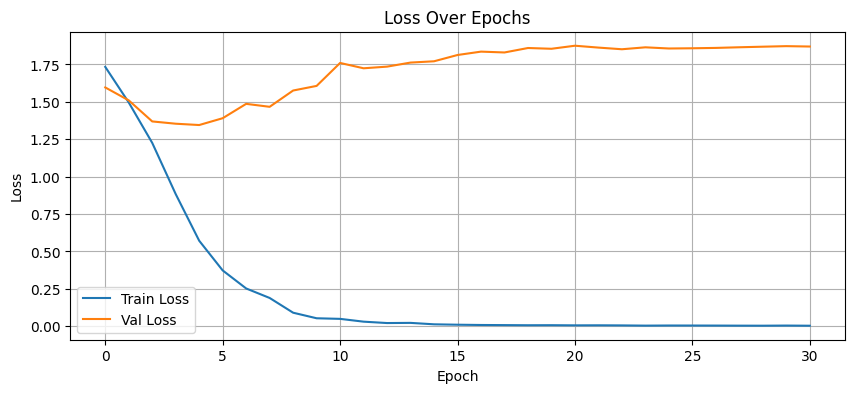

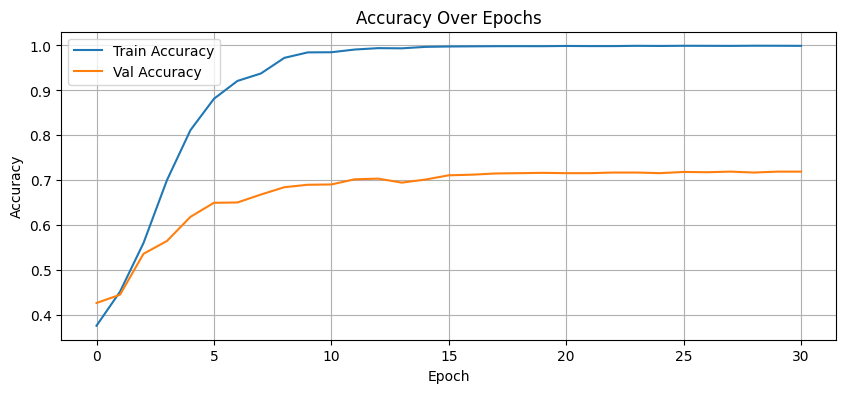

In [ ]:
# 10. Plotting Metrics

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Test Classification Report:
                                  precision    recall  f1-score      support
Billing and Payments              0.861635  0.856250  0.858934   160.000000
Customer Service                  0.665354  0.701245  0.682828   241.000000
General Inquiry                   0.700000  0.583333  0.636364    24.000000
Human Resources                   0.750000  0.685714  0.716418    35.000000
IT Support                        0.705556  0.654639  0.679144   194.000000
Product Support                   0.735192  0.687296  0.710438   307.000000
Returns and Exchanges             0.782051  0.743902  0.762500    82.000000
Sales and Pre-Sales               0.615385  0.627451  0.621359    51.000000
Service Outages and Maintenance   0.836066  0.772727  0.803150    66.000000
Technical Support                 0.729941  0.786920  0.757360   474.000000
accuracy                          0.733782  0.733782  0.733782     0.733782
macro avg                         0.738118  0.709948  0.722

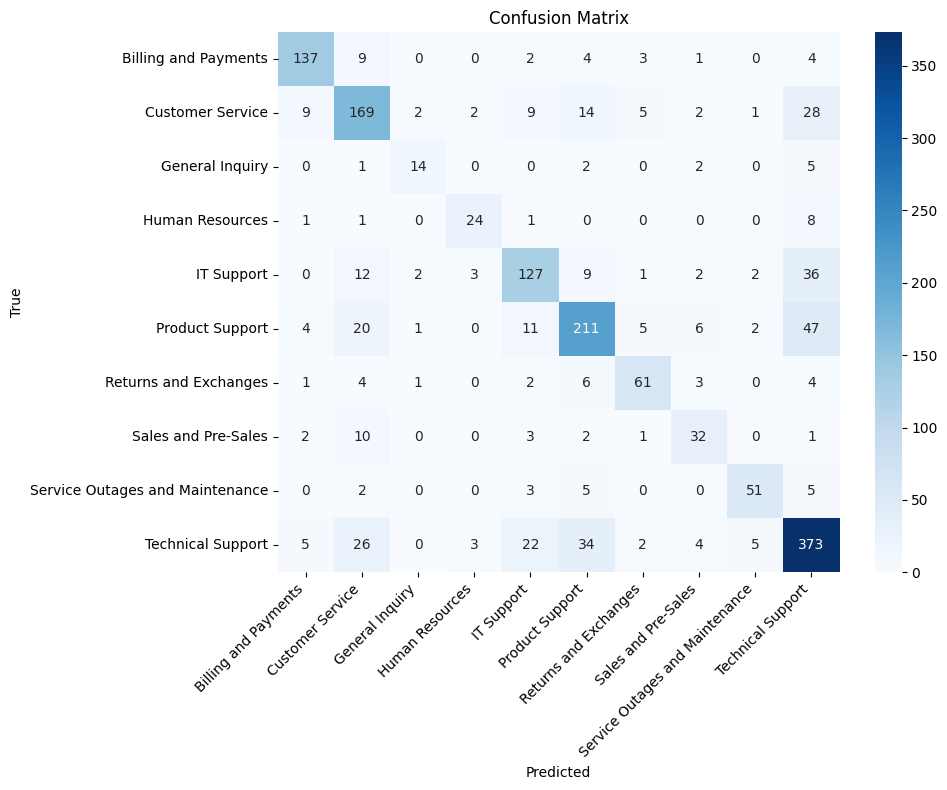

In [ ]:
# 11. Final Test Evaluation and Confusion Matrix

model.load_state_dict(torch.load(checkpoint_path))
test_loss, test_report = eval_model(model, test_loader)

label_names = le.classes_.tolist()
report_named = {
    label_names[int(k)]: v for k, v in test_report.items() if k.isdigit()
}
for key in ["accuracy", "macro avg", "weighted avg"]:
    report_named[key] = test_report[key]

print("Test Classification Report:\n",
      pd.DataFrame(report_named).transpose())

# Confusion Matrix

def get_preds_and_labels(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

all_preds, all_labels = get_preds_and_labels(model, test_loader)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# PreTrained Model - .pt

In [ ]:
# Cell 1 — Setup
!pip -q install transformers==4.41.2 torch scikit-learn

import os, json, numpy as np, torch
from transformers import BertTokenizerFast, AutoConfig, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 344.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Cell 2 — Point to your checkpoint file
PRETRAINED_PT = "pretrained_dept_model.pt"   # <- change if your filename differs
assert os.path.exists(PRETRAINED_PT), "Upload pretrained.pt to Colab first!"


In [ ]:
# Cell 3 — Load state_dict and infer label count
obj = torch.load(PRETRAINED_PT, map_location="cpu")
state_dict = obj["model_state_dict"] if isinstance(obj, dict) and "model_state_dict" in obj else obj

# Infer number of labels from classifier head
clf_key = [k for k in state_dict.keys() if k.endswith("classifier.weight")][0]
num_labels = state_dict[clf_key].shape[0]
print("num_labels:", num_labels)


num_labels: 10


In [ ]:
# Cell 4 — Rebuild tokenizer and model skeleton, then load weights
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
config = AutoConfig.from_pretrained("bert-base-cased", num_labels=num_labels)
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", config=config).to(device)

missing, unexpected = model.load_state_dict(state_dict, strict=False)
print("Loaded. missing:", missing, "unexpected:", unexpected)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded. missing: [] unexpected: []


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Cell 5 — Load class names (if you saved them), else fallback (optional)
classes = None

for cand in ["label_classes.json", "artifacts/dept_pretrained_v1/label_classes.json"]:
    if os.path.exists(cand):
        with open(cand) as f: classes = json.load(f)
        print("Loaded classes from:", cand)
        break

if classes is None and os.path.exists("Cleaned_Tickets.csv"):
    import pandas as pd
    df = pd.read_csv("Cleaned_Tickets.csv")
    le = LabelEncoder().fit(df["department"].astype(str))
    classes = le.classes_.tolist()
    print("Rebuilt classes from CSV (order must match training encoder).")


Rebuilt classes from CSV (order must match training encoder).


In [ ]:
# Cell 6 — Inference helpers
import torch.nn.functional as F

@torch.no_grad()
def predict_pretrained(texts, max_length=128, topk=1):
    enc = tokenizer(
        texts if isinstance(texts, list) else [texts],
        truncation=True, max_length=max_length,
        padding="max_length", return_tensors="pt",
    )
    logits = model(**{k: v.to(device) for k, v in enc.items()}).logits
    probs = F.softmax(logits, dim=-1).cpu().numpy()
    idxs = np.argsort(-probs, axis=1)[:, :topk]
    if classes:
        labels = [[(classes[j], float(probs[i, j])) for j in idxs[i]] for i in range(len(idxs))]
    else:
        labels = [[(int(j), float(probs[i, j])) for j in idxs[i]] for i in range(len(idxs))]
    return labels

# Smoke test
predict_pretrained(["Refund not processed", "Cannot connect to VPN"], topk=3)


[[('Service Outages and Maintenance', 0.5266031622886658),
  ('Product Support', 0.17955495417118073),
  ('Sales and Pre-Sales', 0.17693005502223969)],
 [('IT Support', 0.8594437837600708),
  ('Technical Support', 0.10182513296604156),
  ('Billing and Payments', 0.01678750105202198)]]

In [ ]:
import torch

def show_weights(path):
    obj = torch.load(path, map_location="cpu")
    sd = obj["model_state_dict"] if isinstance(obj, dict) and "model_state_dict" in obj else obj
    print("Total tensors:", len(sd))
    for k, v in list(sd.items())[:8]:
        print(k, tuple(v.shape))
    total_params = sum(p.numel() for p in sd.values())
    print("Total parameters:", f"{total_params:,}")

# Pretrained
show_weights("pretrained_dept_model.pt")

Total tensors: 201
bert.embeddings.word_embeddings.weight (28996, 768)
bert.embeddings.position_embeddings.weight (512, 768)
bert.embeddings.token_type_embeddings.weight (2, 768)
bert.embeddings.LayerNorm.weight (768,)
bert.embeddings.LayerNorm.bias (768,)
bert.encoder.layer.0.attention.self.query.weight (768, 768)
bert.encoder.layer.0.attention.self.query.bias (768,)
bert.encoder.layer.0.attention.self.key.weight (768, 768)
Total parameters: 108,317,962
